In [1]:
import numpy as np
import json
import torch
import sys
from pathlib import Path
from PIL import Image, ImageDraw
from utils import collate_fn, SimpleImageFolder, DataLoader, DataInfo
from sklearn.neighbors import NearestNeighbors 

CODE_PATH = Path('code/')
MODEL_PATH = Path('model/')
IMAGE_PATH = Path('../../data/batch1/keyframes/keyframes_L01/L01_V001/')
SKETCH_PATH = Path('../sketches/')
sys.path.append(str(CODE_PATH))
model_config_file = CODE_PATH / 'training/model_configs/ViT-B-16.json'
model_file = MODEL_PATH / 'tsbir_model_final.pt'

from clip.model import convert_weights, CLIP
from clip.clip import _transform, load, tokenize

In [2]:
if torch.cuda.is_available():
    device = "cuda"  # Use GPU with CUDA
elif torch.backends.mps.is_available():
    device = "mps"  # Use Metal Performance Shaders for Apple Silicon
else:
    device = "cpu"  # Default to CPU

print(f"Using device: {device}")

Using device: mps


In [3]:
with open(model_config_file, 'r') as f:
    model_info = json.load(f)

model = CLIP(**model_info)
loc = device
checkpoint = torch.load(model_file, map_location=loc)

sd = checkpoint["state_dict"]
if next(iter(sd.items()))[0].startswith('module'):
    sd = {k[len('module.'):]: v for k, v in sd.items()}

model.load_state_dict(sd, strict=False)
model.eval()
model = model.to(device)

/var/folders/n3/gsp927h9315ds95n9pgjfkb80000gn/T/ipykernel_19843/1563576942.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file, map_locat

In [4]:
def read_json(file_name):
    with open(file_name) as handle:
        out = json.load(handle)
    return out

convert_weights(model)
preprocess_train = _transform(model.visual.input_resolution, is_train=True)
preprocess_val = _transform(model.visual.input_resolution, is_train=False)
preprocess_fn = (preprocess_train, preprocess_val)

In [5]:
video_img_dict = {}
for path in IMAGE_PATH.glob('*/*/*.jpg'):
    path = str(path)
    video_name = path.rsplit('/', 2)[-2]
    if (video_name not in video_img_dict.keys()):
        video_img_dict[video_name] = [path]
    else:
        video_img_dict[video_name].append(path)

for key in video_img_dict.keys():
    video_img_dict[key].sort()

In [6]:
image_list = []
for item in IMAGE_PATH.glob('*'):
    if '.ipynb' not in str(item):
        image_list.append(str(item))

In [7]:
dataset = SimpleImageFolder(image_list, transform=preprocess_val)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    collate_fn=collate_fn,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    sampler=None,
    drop_last=False,
)
dataloader.num_samples = len(dataset)
dataloader.num_batches = len(dataloader)

data = DataInfo(dataloader, None)

In [8]:
cumulative_loss = 0.0
num_elements = 0.0
all_image_path = []
all_image_features = []
batch_num = 0
model = model.to(device)
with torch.no_grad():
    for batch in dataloader:
        print('Batch: ' + str(batch_num), end='')
        images, image_paths = batch
        images = images.to(device, non_blocking=True)
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        for i in image_features:
            all_image_features.append(i.cpu().numpy())
        for i in image_paths:
            all_image_path.append(i)
            
        batch_num += 1
        print(' -- Done')

Batch: 0 -- Done
Batch: 1 -- Done
Batch: 2 -- Done
Batch: 3 -- Done
Batch: 4 -- Done
Batch: 5 -- Done
Batch: 6 -- Done
Batch: 7 -- Done
Batch: 8 -- Done
Batch: 9 -- Done


In [21]:
all_image_features[22]
# all_image_path[22]

# for i in range(0, len(all_image_path)):
#     if all_image_path[i].rsplit('/', 1)[-1] == '001.jpg':
#         print(i)
#         break

array([-1.1337e-02, -6.4636e-02,  2.5818e-02, -2.9282e-02, -2.7802e-02,
       -4.4495e-02, -1.8234e-02, -5.0140e-02, -3.3508e-02,  1.7090e-03,
        6.5674e-02, -4.6425e-03,  2.5055e-02,  2.7237e-02, -1.2970e-02,
        3.0579e-02, -8.3160e-04, -8.9035e-03, -7.3395e-03,  1.8072e-03,
        2.2842e-02, -1.5495e-02, -3.2440e-02,  3.7659e-02,  1.5434e-02,
        2.6871e-02,  4.1595e-02,  3.6560e-02, -3.9185e-02, -4.6692e-02,
       -5.1636e-02, -3.5248e-02, -5.7312e-02, -8.4839e-02, -6.6872e-03,
        5.3375e-02,  2.7008e-02,  4.3304e-02, -5.0232e-02,  4.8828e-02,
       -3.3073e-03,  2.2369e-02,  7.6294e-03, -5.1666e-02, -8.2550e-03,
       -1.8799e-02,  4.1618e-03,  3.6194e-02, -3.0441e-02,  8.2092e-03,
        1.0455e-01, -1.9485e-02, -5.6244e-02,  4.0070e-02,  1.5472e-02,
       -1.0452e-02,  8.6975e-02,  1.5015e-02, -5.2063e-02,  1.7166e-02,
       -3.1677e-02, -3.2501e-02,  1.0967e-03,  3.6182e-03, -6.6711e-02,
        5.0720e-02,  7.3120e-02, -4.9744e-02, -6.7810e-02, -3.65

In [9]:
def mark_boundary(img, color=(0,255,0)):
    draw = ImageDraw.Draw(img)
    draw.rectangle([5, 5, img.width-5, img.height-5], fill=None, outline=color, width=10)
    return img


def get_concat_hn(ims):
    sum_w = 0
    for im in ims:
        #im = im.resize((256,256))
        sum_w += 256#im.width
        
    max_h = 256#max([im.height for im in ims])
    
    dst = Image.new('RGB', (sum_w ,max_h))
    cur_x = 0
    for im in ims:
        dst.paste(im.resize((256,256)), (cur_x, 0))
        cur_x += 256#im.width
    #dst.paste(im2, (im1.width, 0))
    #dst.paste(im3, (im1.width+im2.width, 0))
    return dst

def get_feature(query_sketch, query_text):
        
    img1 = transformer(query_sketch).unsqueeze(0).to(device)

    txt = tokenize([str(query_text)])[0].unsqueeze(0).to(device)
    with torch.no_grad():
        sketch_feature = model.encode_sketch(img1)
        text_feature = model.encode_text(txt)
        text_feature = text_feature / text_feature.norm(dim=-1, keepdim=True)
        sketch_feature = sketch_feature / sketch_feature.norm(dim=-1, keepdim=True)

    return model.feature_fuse(sketch_feature,text_feature)

In [10]:
feats = all_image_features
image_paths = all_image_path
transformer = preprocess_val
model = model.to(device).eval()

nbrs = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine').fit(feats)

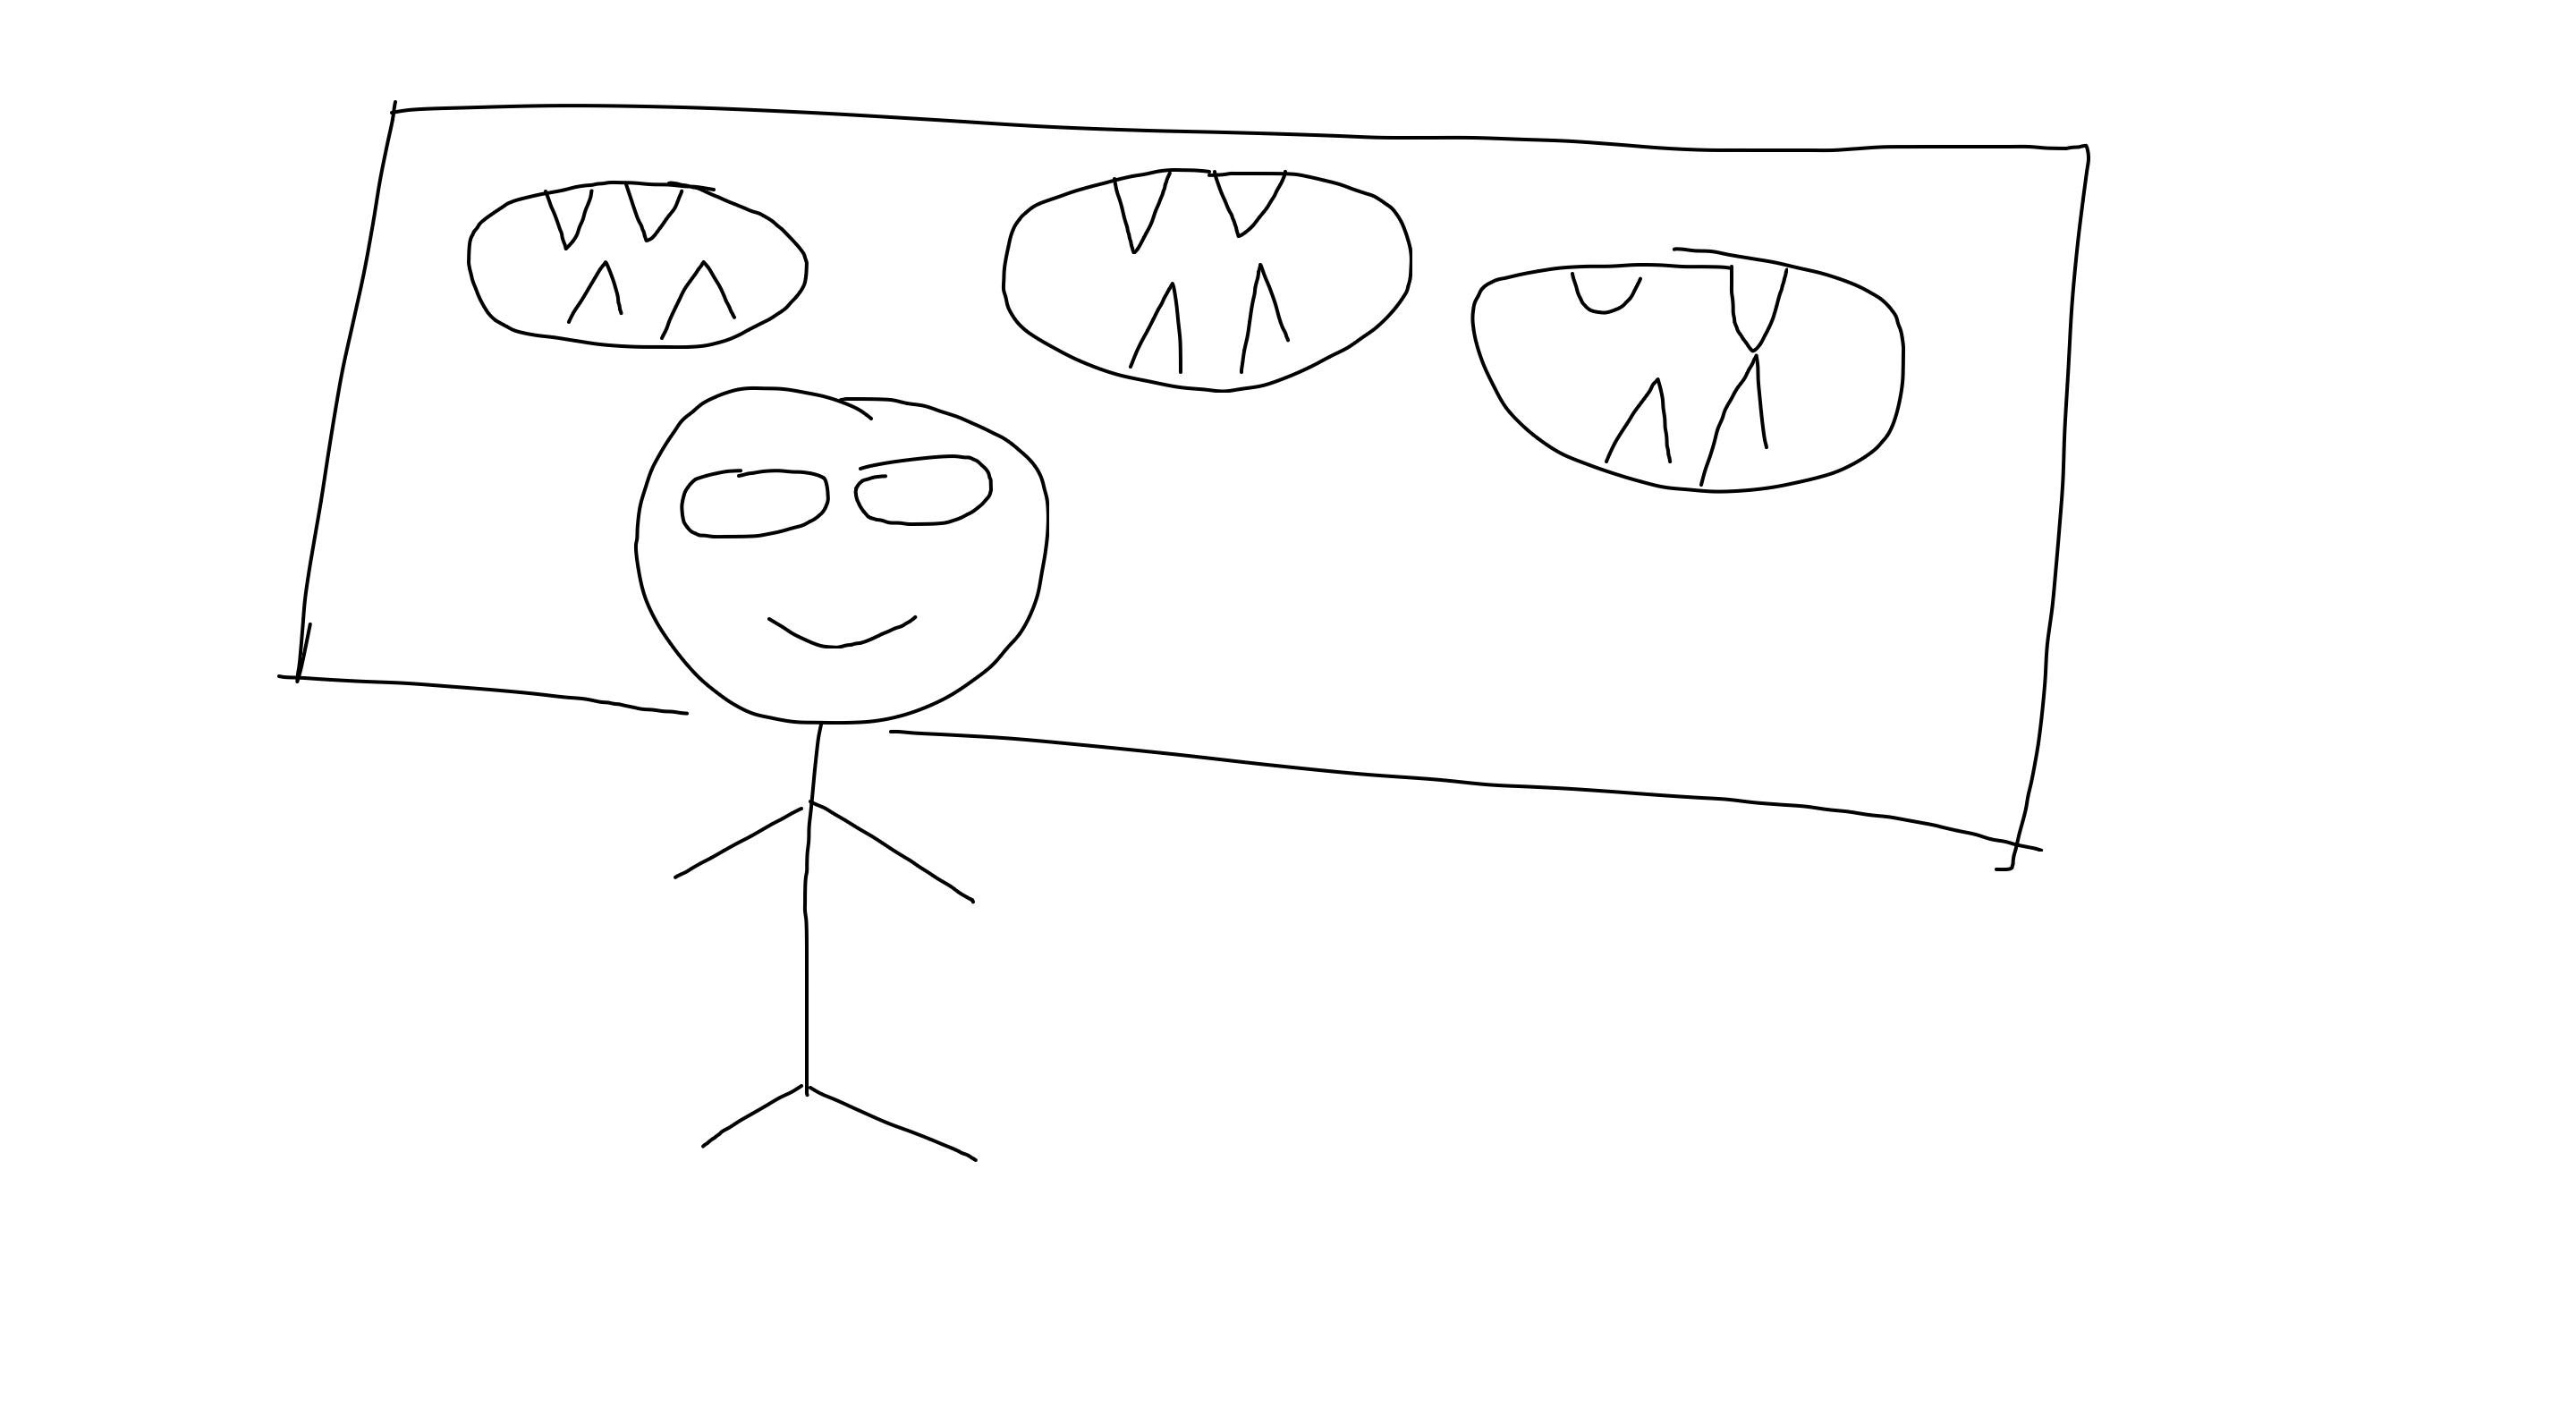

In [11]:
sketch_path = "Drawing.png"
sketch = Image.open(sketch_path)
sketch

In [12]:
caption = 'A man is being interviewed. The wall behind him is covered with shark teeth.'

In [13]:
query_feat = get_feature(sketch, caption)

/Users/VoThinhPhat/Desktop/chatKPT-2024-AIC-HCMC/src/task-former/code/clip/model.py:399: UserWarning: MPS: no support for int64 for argmax_argmin_out, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:815.)
  x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection


In [14]:
def get_image_list(query_feat):
    
    distances, indices = nbrs.kneighbors(query_feat.cpu().numpy())

    im_list = []
    for ind in indices[0]:
        file_loc = image_paths[ind]
        img = Image.open(file_loc)
        try:
            #if using images from COCO benchmark and sketch from our dataset, we can check id and mark the correct one with green border
            imid = int(sketch_path.split('/')[-1].split('_')[2][:-4])
            cur_imid = int(file_loc.split('/')[-1].split('_')[2].split('.')[0])
            if cur_imid == imid:
                img = mark_boundary(img)
        except:
            img = Image.open(file_loc)
        im_list.append(img)
    return im_list

im_list = [sketch] + get_image_list(query_feat)

Caption: A man is being interviewed. The wall behind him is covered with shark teeth.


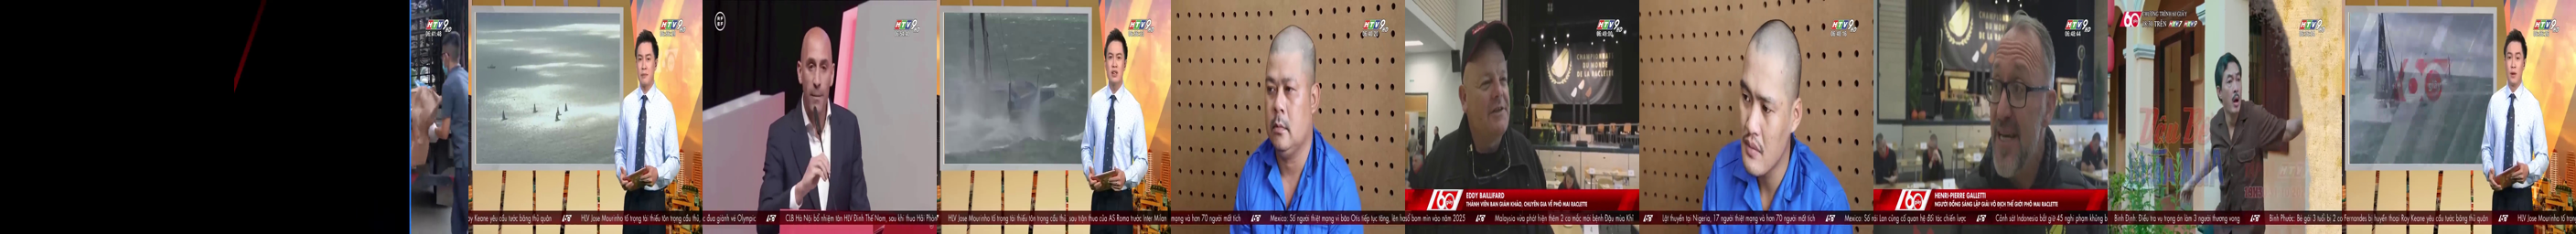

In [15]:
print('Caption: '+ caption)
display(get_concat_hn(im_list)) 